In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
# split the data into train and test parts
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 0]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
    for i in range(1, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
data_df = pd.read_csv('simulation_polynomial.csv', index_col=0)
data_df['sbj'] -= 1

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
data_df

,sbj,trial,value_0,value_1,gaze_0,gaze_1,true_drift_0,true_drift_1,true_threshold,true_ndt,rt,choice
0,0,1,2.939287,3.366231,0.843796,0.156204,0.603554,0.482802,0.906172,0.244761,1.210761,1.0
1,0,2,2.561973,1.904733,0.445410,0.554590,0.658259,0.442678,0.906172,0.244761,0.582761,0.0
2,0,3,2.172226,2.793958,0.724563,0.275437,0.510557,0.570743,0.906172,0.244761,0.713761,0.0
3,0,4,3.492795,2.722823,0.074119,0.925881,0.500520,0.582188,0.906172,0.244761,0.667761,1.0
4,0,5,2.418577,2.422250,0.556938,0.443062,0.558877,0.521397,0.906172,0.244761,1.192761,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19902,99,196,2.023847,2.682980,0.105562,0.894438,0.170663,1.182253,1.609148,0.283313,0.743313,1.0
19903,99,197,1.367823,2.507903,0.627496,0.372504,0.254057,0.794181,1.609148,0.283313,0.932313,0.0
19904,99,198,3.369851,1.650198,0.269569,0.730431,0.776306,0.259907,1.609148,0.283313,3.380313,0.0
19905,99,199,1.729512,2.718103,0.931966,0.068034,0.498002,0.405154,1.609148,0.283313,0.694313,0.0


In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.3)

obs_train = np.asarray(tr_df[['rt', 'choice', 'sbj']])
X_train = np.asarray(tr_df[['value_0', 'value_1', 'gaze_0', 'gaze_1']])

obs_test = np.asarray(ts_df[['rt', 'choice', 'sbj']])
X_test = np.asarray(ts_df[['value_0', 'value_1', 'gaze_0', 'gaze_1']])

print(X_train.shape, X_test.shape)

(13926, 4) (5981, 4)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 1e-20)), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 312       
                                                                 
Total params: 605 (2.36 KB)
Trainable params: 605 (2.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [10]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=5000)

Epoch 1/5000
1/1 [==============================] - 1s 591ms/step - loss: 81949.4531
Epoch 2/5000
1/1 [==============================] - 0s 4ms/step - loss: 81467.5859
Epoch 3/5000
1/1 [==============================] - 0s 4ms/step - loss: 81136.8438
Epoch 4/5000
1/1 [==============================] - 0s 4ms/step - loss: 80870.8906
Epoch 5/5000
1/1 [==============================] - 0s 5ms/step - loss: 80642.5312
Epoch 6/5000
1/1 [==============================] - 0s 5ms/step - loss: 80439.0625
Epoch 7/5000
1/1 [==============================] - 0s 4ms/step - loss: 80253.2812
Epoch 8/5000
1/1 [==============================] - 0s 4ms/step - loss: 80080.6250
Epoch 9/5000
1/1 [==============================] - 0s 6ms/step - loss: 79917.8984
Epoch 10/5000
1/1 [==============================] - 0s 4ms/step - loss: 79762.8828
Epoch 11/5000
1/1 [==============================] - 0s 4ms/step - loss: 79613.9219
Epoch 12/5000
1/1 [==============================] - 0s 6ms/step - loss: 79469.9375

1/1 [==============================] - 0s 5ms/step - loss: 71134.9375
Epoch 99/5000
1/1 [==============================] - 0s 6ms/step - loss: 71062.3047
Epoch 100/5000
1/1 [==============================] - 0s 5ms/step - loss: 70990.1094
Epoch 101/5000
1/1 [==============================] - 0s 6ms/step - loss: 70918.3750
Epoch 102/5000
1/1 [==============================] - 0s 6ms/step - loss: 70847.0781
Epoch 103/5000
1/1 [==============================] - 0s 5ms/step - loss: 70776.2188
Epoch 104/5000
1/1 [==============================] - 0s 5ms/step - loss: 70705.7969
Epoch 105/5000
1/1 [==============================] - 0s 5ms/step - loss: 70635.8203
Epoch 106/5000
1/1 [==============================] - 0s 5ms/step - loss: 70566.2578
Epoch 107/5000
1/1 [==============================] - 0s 6ms/step - loss: 70497.1328
Epoch 108/5000
1/1 [==============================] - 0s 5ms/step - loss: 70428.4219
Epoch 109/5000
1/1 [==============================] - 0s 5ms/step - loss: 70360.1

1/1 [==============================] - 0s 5ms/step - loss: 65779.1484
Epoch 195/5000
1/1 [==============================] - 0s 6ms/step - loss: 65736.3984
Epoch 196/5000
1/1 [==============================] - 0s 5ms/step - loss: 65693.8438
Epoch 197/5000
1/1 [==============================] - 0s 5ms/step - loss: 65651.4844
Epoch 198/5000
1/1 [==============================] - 0s 5ms/step - loss: 65609.3281
Epoch 199/5000
1/1 [==============================] - 0s 5ms/step - loss: 65567.3594
Epoch 200/5000
1/1 [==============================] - 0s 5ms/step - loss: 65525.5742
Epoch 201/5000
1/1 [==============================] - 0s 5ms/step - loss: 65483.9844
Epoch 202/5000
1/1 [==============================] - 0s 5ms/step - loss: 65442.5820
Epoch 203/5000
1/1 [==============================] - 0s 5ms/step - loss: 65401.3594
Epoch 204/5000
1/1 [==============================] - 0s 5ms/step - loss: 65360.3203
Epoch 205/5000
1/1 [==============================] - 0s 5ms/step - loss: 65319.

1/1 [==============================] - 0s 5ms/step - loss: 62378.3906
Epoch 291/5000
1/1 [==============================] - 0s 6ms/step - loss: 62348.7578
Epoch 292/5000
1/1 [==============================] - 0s 5ms/step - loss: 62319.2109
Epoch 293/5000
1/1 [==============================] - 0s 5ms/step - loss: 62289.7578
Epoch 294/5000
1/1 [==============================] - 0s 5ms/step - loss: 62260.3906
Epoch 295/5000
1/1 [==============================] - 0s 5ms/step - loss: 62231.1133
Epoch 296/5000
1/1 [==============================] - 0s 5ms/step - loss: 62201.9141
Epoch 297/5000
1/1 [==============================] - 0s 6ms/step - loss: 62172.8047
Epoch 298/5000
1/1 [==============================] - 0s 5ms/step - loss: 62143.7812
Epoch 299/5000
1/1 [==============================] - 0s 5ms/step - loss: 62114.8320
Epoch 300/5000
1/1 [==============================] - 0s 5ms/step - loss: 62085.9727
Epoch 301/5000
1/1 [==============================] - 0s 5ms/step - loss: 62057.

1/1 [==============================] - 0s 6ms/step - loss: 59754.3008
Epoch 387/5000
1/1 [==============================] - 0s 5ms/step - loss: 59727.5703
Epoch 388/5000
1/1 [==============================] - 0s 5ms/step - loss: 59700.7969
Epoch 389/5000
1/1 [==============================] - 0s 5ms/step - loss: 59673.9766
Epoch 390/5000
1/1 [==============================] - 0s 5ms/step - loss: 59647.0859
Epoch 391/5000
1/1 [==============================] - 0s 5ms/step - loss: 59620.1172
Epoch 392/5000
1/1 [==============================] - 0s 5ms/step - loss: 59593.0586
Epoch 393/5000
1/1 [==============================] - 0s 5ms/step - loss: 59565.8828
Epoch 394/5000
1/1 [==============================] - 0s 4ms/step - loss: 59538.5703
Epoch 395/5000
1/1 [==============================] - 0s 6ms/step - loss: 59511.1055
Epoch 396/5000
1/1 [==============================] - 0s 5ms/step - loss: 59483.4805
Epoch 397/5000
1/1 [==============================] - 0s 5ms/step - loss: 59455.

1/1 [==============================] - 0s 5ms/step - loss: 57000.5938
Epoch 483/5000
1/1 [==============================] - 0s 5ms/step - loss: 56972.7422
Epoch 484/5000
1/1 [==============================] - 0s 6ms/step - loss: 56944.9453
Epoch 485/5000
1/1 [==============================] - 0s 5ms/step - loss: 56917.1055
Epoch 486/5000
1/1 [==============================] - 0s 5ms/step - loss: 56889.3086
Epoch 487/5000
1/1 [==============================] - 0s 6ms/step - loss: 56861.4648
Epoch 488/5000
1/1 [==============================] - 0s 5ms/step - loss: 56833.6719
Epoch 489/5000
1/1 [==============================] - 0s 5ms/step - loss: 56805.8164
Epoch 490/5000
1/1 [==============================] - 0s 5ms/step - loss: 56778.0234
Epoch 491/5000
1/1 [==============================] - 0s 5ms/step - loss: 56750.1719
Epoch 492/5000
1/1 [==============================] - 0s 5ms/step - loss: 56722.3672
Epoch 493/5000
1/1 [==============================] - 0s 6ms/step - loss: 56694.

1/1 [==============================] - 0s 6ms/step - loss: 54226.4766
Epoch 579/5000
1/1 [==============================] - 0s 5ms/step - loss: 54198.5430
Epoch 580/5000
1/1 [==============================] - 0s 5ms/step - loss: 54170.7500
Epoch 581/5000
1/1 [==============================] - 0s 5ms/step - loss: 54142.9766
Epoch 582/5000
1/1 [==============================] - 0s 5ms/step - loss: 54115.3281
Epoch 583/5000
1/1 [==============================] - 0s 5ms/step - loss: 54087.6914
Epoch 584/5000
1/1 [==============================] - 0s 5ms/step - loss: 54060.1875
Epoch 585/5000
1/1 [==============================] - 0s 5ms/step - loss: 54032.6875
Epoch 586/5000
1/1 [==============================] - 0s 5ms/step - loss: 54005.3086
Epoch 587/5000
1/1 [==============================] - 0s 5ms/step - loss: 53977.9375
Epoch 588/5000
1/1 [==============================] - 0s 5ms/step - loss: 53950.6875
Epoch 589/5000
1/1 [==============================] - 0s 5ms/step - loss: 53923.

1/1 [==============================] - 0s 5ms/step - loss: 51756.1172
Epoch 675/5000
1/1 [==============================] - 0s 5ms/step - loss: 51731.3984
Epoch 676/5000
1/1 [==============================] - 0s 5ms/step - loss: 51706.7773
Epoch 677/5000
1/1 [==============================] - 0s 5ms/step - loss: 51682.0664
Epoch 678/5000
1/1 [==============================] - 0s 5ms/step - loss: 51657.4844
Epoch 679/5000
1/1 [==============================] - 0s 5ms/step - loss: 51632.7969
Epoch 680/5000
1/1 [==============================] - 0s 6ms/step - loss: 51608.2422
Epoch 681/5000
1/1 [==============================] - 0s 5ms/step - loss: 51583.6016
Epoch 682/5000
1/1 [==============================] - 0s 5ms/step - loss: 51559.0859
Epoch 683/5000
1/1 [==============================] - 0s 5ms/step - loss: 51534.4922
Epoch 684/5000
1/1 [==============================] - 0s 5ms/step - loss: 51510.0430
Epoch 685/5000
1/1 [==============================] - 0s 5ms/step - loss: 51485.

1/1 [==============================] - 0s 6ms/step - loss: 49606.0859
Epoch 771/5000
1/1 [==============================] - 0s 5ms/step - loss: 49586.2891
Epoch 772/5000
1/1 [==============================] - 0s 5ms/step - loss: 49566.6562
Epoch 773/5000
1/1 [==============================] - 0s 5ms/step - loss: 49546.9648
Epoch 774/5000
1/1 [==============================] - 0s 5ms/step - loss: 49527.4297
Epoch 775/5000
1/1 [==============================] - 0s 5ms/step - loss: 49507.8359
Epoch 776/5000
1/1 [==============================] - 0s 5ms/step - loss: 49488.3867
Epoch 777/5000
1/1 [==============================] - 0s 5ms/step - loss: 49468.8906
Epoch 778/5000
1/1 [==============================] - 0s 5ms/step - loss: 49449.5312
Epoch 779/5000
1/1 [==============================] - 0s 5ms/step - loss: 49430.1250
Epoch 780/5000
1/1 [==============================] - 0s 5ms/step - loss: 49410.8555
Epoch 781/5000
1/1 [==============================] - 0s 5ms/step - loss: 49391.

1/1 [==============================] - 0s 6ms/step - loss: 47883.7734
Epoch 867/5000
1/1 [==============================] - 0s 5ms/step - loss: 47867.3242
Epoch 868/5000
1/1 [==============================] - 0s 5ms/step - loss: 47850.9727
Epoch 869/5000
1/1 [==============================] - 0s 6ms/step - loss: 47834.5938
Epoch 870/5000
1/1 [==============================] - 0s 5ms/step - loss: 47818.3047
Epoch 871/5000
1/1 [==============================] - 0s 5ms/step - loss: 47801.9688
Epoch 872/5000
1/1 [==============================] - 0s 5ms/step - loss: 47785.7344
Epoch 873/5000
1/1 [==============================] - 0s 5ms/step - loss: 47769.4648
Epoch 874/5000
1/1 [==============================] - 0s 5ms/step - loss: 47753.2852
Epoch 875/5000
1/1 [==============================] - 0s 5ms/step - loss: 47737.0703
Epoch 876/5000
1/1 [==============================] - 0s 5ms/step - loss: 47720.9531
Epoch 877/5000
1/1 [==============================] - 0s 5ms/step - loss: 47704.

1/1 [==============================] - 0s 5ms/step - loss: 46439.0312
Epoch 963/5000
1/1 [==============================] - 0s 5ms/step - loss: 46425.3008
Epoch 964/5000
1/1 [==============================] - 0s 5ms/step - loss: 46411.7422
Epoch 965/5000
1/1 [==============================] - 0s 5ms/step - loss: 46398.0781
Epoch 966/5000
1/1 [==============================] - 0s 5ms/step - loss: 46384.5781
Epoch 967/5000
1/1 [==============================] - 0s 5ms/step - loss: 46370.9531
Epoch 968/5000
1/1 [==============================] - 0s 5ms/step - loss: 46357.5000
Epoch 969/5000
1/1 [==============================] - 0s 5ms/step - loss: 46343.9453
Epoch 970/5000
1/1 [==============================] - 0s 5ms/step - loss: 46330.5547
Epoch 971/5000
1/1 [==============================] - 0s 5ms/step - loss: 46317.0469
Epoch 972/5000
1/1 [==============================] - 0s 5ms/step - loss: 46303.7148
Epoch 973/5000
1/1 [==============================] - 0s 6ms/step - loss: 46290.

1/1 [==============================] - 0s 5ms/step - loss: 45264.2891
Epoch 1058/5000
1/1 [==============================] - 0s 5ms/step - loss: 45253.3047
Epoch 1059/5000
1/1 [==============================] - 0s 5ms/step - loss: 45242.1172
Epoch 1060/5000
1/1 [==============================] - 0s 5ms/step - loss: 45231.1836
Epoch 1061/5000
1/1 [==============================] - 0s 5ms/step - loss: 45220.0508
Epoch 1062/5000
1/1 [==============================] - 0s 5ms/step - loss: 45209.1680
Epoch 1063/5000
1/1 [==============================] - 0s 5ms/step - loss: 45198.0859
Epoch 1064/5000
1/1 [==============================] - 0s 5ms/step - loss: 45187.2734
Epoch 1065/5000
1/1 [==============================] - 0s 5ms/step - loss: 45176.2383
Epoch 1066/5000
1/1 [==============================] - 0s 5ms/step - loss: 45165.4766
Epoch 1067/5000
1/1 [==============================] - 0s 5ms/step - loss: 45154.4922
Epoch 1068/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 44323.3008
Epoch 1153/5000
1/1 [==============================] - 0s 6ms/step - loss: 44314.4531
Epoch 1154/5000
1/1 [==============================] - 0s 5ms/step - loss: 44305.9102
Epoch 1155/5000
1/1 [==============================] - 0s 5ms/step - loss: 44297.1094
Epoch 1156/5000
1/1 [==============================] - 0s 6ms/step - loss: 44288.6094
Epoch 1157/5000
1/1 [==============================] - 0s 5ms/step - loss: 44279.8555
Epoch 1158/5000
1/1 [==============================] - 0s 5ms/step - loss: 44271.4141
Epoch 1159/5000
1/1 [==============================] - 0s 5ms/step - loss: 44262.6992
Epoch 1160/5000
1/1 [==============================] - 0s 5ms/step - loss: 44254.2891
Epoch 1161/5000
1/1 [==============================] - 0s 5ms/step - loss: 44245.6289
Epoch 1162/5000
1/1 [==============================] - 0s 6ms/step - loss: 44237.2773
Epoch 1163/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 43595.3359
Epoch 1248/5000
1/1 [==============================] - 0s 5ms/step - loss: 43588.8398
Epoch 1249/5000
1/1 [==============================] - 0s 5ms/step - loss: 43582.0000
Epoch 1250/5000
1/1 [==============================] - 0s 5ms/step - loss: 43575.5312
Epoch 1251/5000
1/1 [==============================] - 0s 5ms/step - loss: 43568.7500
Epoch 1252/5000
1/1 [==============================] - 0s 5ms/step - loss: 43562.3203
Epoch 1253/5000
1/1 [==============================] - 0s 5ms/step - loss: 43555.5664
Epoch 1254/5000
1/1 [==============================] - 0s 5ms/step - loss: 43549.1914
Epoch 1255/5000
1/1 [==============================] - 0s 5ms/step - loss: 43542.4688
Epoch 1256/5000
1/1 [==============================] - 0s 5ms/step - loss: 43536.1328
Epoch 1257/5000
1/1 [==============================] - 0s 5ms/step - loss: 43529.4492
Epoch 1258/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 43042.5703
Epoch 1343/5000
1/1 [==============================] - 0s 5ms/step - loss: 43037.3438
Epoch 1344/5000
1/1 [==============================] - 0s 5ms/step - loss: 43032.5508
Epoch 1345/5000
1/1 [==============================] - 0s 5ms/step - loss: 43027.3477
Epoch 1346/5000
1/1 [==============================] - 0s 5ms/step - loss: 43022.5977
Epoch 1347/5000
1/1 [==============================] - 0s 6ms/step - loss: 43017.4023
Epoch 1348/5000
1/1 [==============================] - 0s 5ms/step - loss: 43012.6758
Epoch 1349/5000
1/1 [==============================] - 0s 5ms/step - loss: 43007.5117
Epoch 1350/5000
1/1 [==============================] - 0s 6ms/step - loss: 43002.7969
Epoch 1351/5000
1/1 [==============================] - 0s 5ms/step - loss: 42997.6797
Epoch 1352/5000
1/1 [==============================] - 0s 5ms/step - loss: 42993.0039
Epoch 1353/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 42623.1719
Epoch 1438/5000
1/1 [==============================] - 0s 5ms/step - loss: 42619.5898
Epoch 1439/5000
1/1 [==============================] - 0s 6ms/step - loss: 42615.4883
Epoch 1440/5000
1/1 [==============================] - 0s 5ms/step - loss: 42611.9219
Epoch 1441/5000
1/1 [==============================] - 0s 6ms/step - loss: 42607.8477
Epoch 1442/5000
1/1 [==============================] - 0s 5ms/step - loss: 42604.3047
Epoch 1443/5000
1/1 [==============================] - 0s 5ms/step - loss: 42600.2461
Epoch 1444/5000
1/1 [==============================] - 0s 6ms/step - loss: 42596.7344
Epoch 1445/5000
1/1 [==============================] - 0s 5ms/step - loss: 42592.6875
Epoch 1446/5000
1/1 [==============================] - 0s 5ms/step - loss: 42589.1953
Epoch 1447/5000
1/1 [==============================] - 0s 5ms/step - loss: 42585.1797
Epoch 1448/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 42303.6953
Epoch 1533/5000
1/1 [==============================] - 0s 5ms/step - loss: 42300.4531
Epoch 1534/5000
1/1 [==============================] - 0s 5ms/step - loss: 42297.8594
Epoch 1535/5000
1/1 [==============================] - 0s 6ms/step - loss: 42294.6562
Epoch 1536/5000
1/1 [==============================] - 0s 5ms/step - loss: 42292.0742
Epoch 1537/5000
1/1 [==============================] - 0s 5ms/step - loss: 42288.8672
Epoch 1538/5000
1/1 [==============================] - 0s 5ms/step - loss: 42286.3203
Epoch 1539/5000
1/1 [==============================] - 0s 5ms/step - loss: 42283.1406
Epoch 1540/5000
1/1 [==============================] - 0s 6ms/step - loss: 42280.5938
Epoch 1541/5000
1/1 [==============================] - 0s 5ms/step - loss: 42277.4258
Epoch 1542/5000
1/1 [==============================] - 0s 5ms/step - loss: 42274.9141
Epoch 1543/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 42059.1211
Epoch 1628/5000
1/1 [==============================] - 0s 6ms/step - loss: 42057.2188
Epoch 1629/5000
1/1 [==============================] - 0s 6ms/step - loss: 42054.5859
Epoch 1630/5000
1/1 [==============================] - 0s 6ms/step - loss: 42052.7109
Epoch 1631/5000
1/1 [==============================] - 0s 6ms/step - loss: 42050.0898
Epoch 1632/5000
1/1 [==============================] - 0s 6ms/step - loss: 42048.2266
Epoch 1633/5000
1/1 [==============================] - 0s 6ms/step - loss: 42045.6328
Epoch 1634/5000
1/1 [==============================] - 0s 6ms/step - loss: 42043.7656
Epoch 1635/5000
1/1 [==============================] - 0s 6ms/step - loss: 42041.1797
Epoch 1636/5000
1/1 [==============================] - 0s 6ms/step - loss: 42039.3398
Epoch 1637/5000
1/1 [==============================] - 0s 6ms/step - loss: 42036.7422
Epoch 1638/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 41868.6719
Epoch 1723/5000
1/1 [==============================] - 0s 7ms/step - loss: 41866.4727
Epoch 1724/5000
1/1 [==============================] - 0s 5ms/step - loss: 41865.1289
Epoch 1725/5000
1/1 [==============================] - 0s 6ms/step - loss: 41862.9688
Epoch 1726/5000
1/1 [==============================] - 0s 5ms/step - loss: 41861.6172
Epoch 1727/5000
1/1 [==============================] - 0s 5ms/step - loss: 41859.4531
Epoch 1728/5000
1/1 [==============================] - 0s 6ms/step - loss: 41858.1250
Epoch 1729/5000
1/1 [==============================] - 0s 6ms/step - loss: 41855.9766
Epoch 1730/5000
1/1 [==============================] - 0s 5ms/step - loss: 41854.6562
Epoch 1731/5000
1/1 [==============================] - 0s 6ms/step - loss: 41852.5078
Epoch 1732/5000
1/1 [==============================] - 0s 5ms/step - loss: 41851.2031
Epoch 1733/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 41718.0781
Epoch 1818/5000
1/1 [==============================] - 0s 5ms/step - loss: 41717.1250
Epoch 1819/5000
1/1 [==============================] - 0s 5ms/step - loss: 41715.2578
Epoch 1820/5000
1/1 [==============================] - 0s 6ms/step - loss: 41714.3086
Epoch 1821/5000
1/1 [==============================] - 0s 6ms/step - loss: 41712.4570
Epoch 1822/5000
1/1 [==============================] - 0s 5ms/step - loss: 41711.5156
Epoch 1823/5000
1/1 [==============================] - 0s 6ms/step - loss: 41709.6602
Epoch 1824/5000
1/1 [==============================] - 0s 5ms/step - loss: 41708.7266
Epoch 1825/5000
1/1 [==============================] - 0s 6ms/step - loss: 41706.8672
Epoch 1826/5000
1/1 [==============================] - 0s 5ms/step - loss: 41705.9453
Epoch 1827/5000
1/1 [==============================] - 0s 5ms/step - loss: 41704.1133
Epoch 1828/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 41597.5859
Epoch 1913/5000
1/1 [==============================] - 0s 5ms/step - loss: 41595.9492
Epoch 1914/5000
1/1 [==============================] - 0s 6ms/step - loss: 41595.2930
Epoch 1915/5000
1/1 [==============================] - 0s 5ms/step - loss: 41593.6562
Epoch 1916/5000
1/1 [==============================] - 0s 5ms/step - loss: 41593.0469
Epoch 1917/5000
1/1 [==============================] - 0s 5ms/step - loss: 41591.4062
Epoch 1918/5000
1/1 [==============================] - 0s 6ms/step - loss: 41590.7734
Epoch 1919/5000
1/1 [==============================] - 0s 5ms/step - loss: 41589.1328
Epoch 1920/5000
1/1 [==============================] - 0s 5ms/step - loss: 41588.5156
Epoch 1921/5000
1/1 [==============================] - 0s 5ms/step - loss: 41586.8750
Epoch 1922/5000
1/1 [==============================] - 0s 5ms/step - loss: 41586.2578
Epoch 1923/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 41498.6680
Epoch 2008/5000
1/1 [==============================] - 0s 5ms/step - loss: 41498.2773
Epoch 2009/5000
1/1 [==============================] - 0s 6ms/step - loss: 41496.8125
Epoch 2010/5000
1/1 [==============================] - 0s 5ms/step - loss: 41496.4141
Epoch 2011/5000
1/1 [==============================] - 0s 6ms/step - loss: 41494.9492
Epoch 2012/5000
1/1 [==============================] - 0s 5ms/step - loss: 41494.5742
Epoch 2013/5000
1/1 [==============================] - 0s 5ms/step - loss: 41493.1172
Epoch 2014/5000
1/1 [==============================] - 0s 5ms/step - loss: 41492.7812
Epoch 2015/5000
1/1 [==============================] - 0s 6ms/step - loss: 41491.3047
Epoch 2016/5000
1/1 [==============================] - 0s 5ms/step - loss: 41490.9141
Epoch 2017/5000
1/1 [==============================] - 0s 5ms/step - loss: 41489.4180
Epoch 2018/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 41419.1719
Epoch 2103/5000
1/1 [==============================] - 0s 6ms/step - loss: 41417.8242
Epoch 2104/5000
1/1 [==============================] - 0s 6ms/step - loss: 41417.6602
Epoch 2105/5000
1/1 [==============================] - 0s 5ms/step - loss: 41416.3320
Epoch 2106/5000
1/1 [==============================] - 0s 6ms/step - loss: 41416.1445
Epoch 2107/5000
1/1 [==============================] - 0s 5ms/step - loss: 41414.8320
Epoch 2108/5000
1/1 [==============================] - 0s 6ms/step - loss: 41414.6562
Epoch 2109/5000
1/1 [==============================] - 0s 6ms/step - loss: 41413.3203
Epoch 2110/5000
1/1 [==============================] - 0s 5ms/step - loss: 41413.1133
Epoch 2111/5000
1/1 [==============================] - 0s 5ms/step - loss: 41411.8359
Epoch 2112/5000
1/1 [==============================] - 0s 5ms/step - loss: 41411.5938
Epoch 2113/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 41353.3906
Epoch 2198/5000
1/1 [==============================] - 0s 6ms/step - loss: 41353.3438
Epoch 2199/5000
1/1 [==============================] - 0s 5ms/step - loss: 41352.1289
Epoch 2200/5000
1/1 [==============================] - 0s 5ms/step - loss: 41352.0820
Epoch 2201/5000
1/1 [==============================] - 0s 6ms/step - loss: 41350.8906
Epoch 2202/5000
1/1 [==============================] - 0s 5ms/step - loss: 41350.9062
Epoch 2203/5000
1/1 [==============================] - 0s 6ms/step - loss: 41349.6562
Epoch 2204/5000
1/1 [==============================] - 0s 6ms/step - loss: 41349.7188
Epoch 2205/5000
1/1 [==============================] - 0s 6ms/step - loss: 41348.3906
Epoch 2206/5000
1/1 [==============================] - 0s 6ms/step - loss: 41348.4414
Epoch 2207/5000
1/1 [==============================] - 0s 6ms/step - loss: 41347.2266
Epoch 2208/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 41300.3047
Epoch 2293/5000
1/1 [==============================] - 0s 6ms/step - loss: 41299.2422
Epoch 2294/5000
1/1 [==============================] - 0s 6ms/step - loss: 41299.4219
Epoch 2295/5000
1/1 [==============================] - 0s 5ms/step - loss: 41298.2734
Epoch 2296/5000
1/1 [==============================] - 0s 6ms/step - loss: 41298.2500
Epoch 2297/5000
1/1 [==============================] - 0s 5ms/step - loss: 41297.2969
Epoch 2298/5000
1/1 [==============================] - 0s 5ms/step - loss: 41297.2539
Epoch 2299/5000
1/1 [==============================] - 0s 5ms/step - loss: 41296.2969
Epoch 2300/5000
1/1 [==============================] - 0s 5ms/step - loss: 41296.3711
Epoch 2301/5000
1/1 [==============================] - 0s 6ms/step - loss: 41295.2109
Epoch 2302/5000
1/1 [==============================] - 0s 5ms/step - loss: 41295.3945
Epoch 2303/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 41255.9062
Epoch 2388/5000
1/1 [==============================] - 0s 6ms/step - loss: 41256.4062
Epoch 2389/5000
1/1 [==============================] - 0s 6ms/step - loss: 41255.1680
Epoch 2390/5000
1/1 [==============================] - 0s 5ms/step - loss: 41255.2930
Epoch 2391/5000
1/1 [==============================] - 0s 6ms/step - loss: 41254.2930
Epoch 2392/5000
1/1 [==============================] - 0s 5ms/step - loss: 41254.5938
Epoch 2393/5000
1/1 [==============================] - 0s 5ms/step - loss: 41253.5547
Epoch 2394/5000
1/1 [==============================] - 0s 6ms/step - loss: 41253.7383
Epoch 2395/5000
1/1 [==============================] - 0s 6ms/step - loss: 41252.7734
Epoch 2396/5000
1/1 [==============================] - 0s 5ms/step - loss: 41252.9570
Epoch 2397/5000
1/1 [==============================] - 0s 5ms/step - loss: 41251.7734
Epoch 2398/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 41220.7031
Epoch 2483/5000
1/1 [==============================] - 0s 5ms/step - loss: 41219.5430
Epoch 2484/5000
1/1 [==============================] - 0s 6ms/step - loss: 41220.1094
Epoch 2485/5000
1/1 [==============================] - 0s 5ms/step - loss: 41219.0312
Epoch 2486/5000
1/1 [==============================] - 0s 5ms/step - loss: 41219.2656
Epoch 2487/5000
1/1 [==============================] - 0s 5ms/step - loss: 41218.3398
Epoch 2488/5000
1/1 [==============================] - 0s 5ms/step - loss: 41218.7891
Epoch 2489/5000
1/1 [==============================] - 0s 5ms/step - loss: 41217.5352
Epoch 2490/5000
1/1 [==============================] - 0s 6ms/step - loss: 41218.3516
Epoch 2491/5000
1/1 [==============================] - 0s 5ms/step - loss: 41217.1484
Epoch 2492/5000
1/1 [==============================] - 0s 5ms/step - loss: 41217.4219
Epoch 2493/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 41190.4766
Epoch 2578/5000
1/1 [==============================] - 0s 6ms/step - loss: 41190.9883
Epoch 2579/5000
1/1 [==============================] - 0s 5ms/step - loss: 41190.0469
Epoch 2580/5000
1/1 [==============================] - 0s 5ms/step - loss: 41190.3086
Epoch 2581/5000
1/1 [==============================] - 0s 6ms/step - loss: 41189.2578
Epoch 2582/5000
1/1 [==============================] - 0s 5ms/step - loss: 41190.0039
Epoch 2583/5000
1/1 [==============================] - 0s 5ms/step - loss: 41189.0000
Epoch 2584/5000
1/1 [==============================] - 0s 5ms/step - loss: 41189.3711
Epoch 2585/5000
1/1 [==============================] - 0s 5ms/step - loss: 41188.4531
Epoch 2586/5000
1/1 [==============================] - 0s 5ms/step - loss: 41188.6680
Epoch 2587/5000
1/1 [==============================] - 0s 5ms/step - loss: 41187.8203
Epoch 2588/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 41167.0781
Epoch 2673/5000
1/1 [==============================] - 0s 11ms/step - loss: 41166.0508
Epoch 2674/5000
1/1 [==============================] - 0s 6ms/step - loss: 41166.6562
Epoch 2675/5000
1/1 [==============================] - 0s 6ms/step - loss: 41165.7109
Epoch 2676/5000
1/1 [==============================] - 0s 5ms/step - loss: 41166.2070
Epoch 2677/5000
1/1 [==============================] - 0s 6ms/step - loss: 41165.4844
Epoch 2678/5000
1/1 [==============================] - 0s 6ms/step - loss: 41165.6797
Epoch 2679/5000
1/1 [==============================] - 0s 5ms/step - loss: 41164.7852
Epoch 2680/5000
1/1 [==============================] - 0s 6ms/step - loss: 41164.7227
Epoch 2681/5000
1/1 [==============================] - 0s 5ms/step - loss: 41164.1250
Epoch 2682/5000
1/1 [==============================] - 0s 5ms/step - loss: 41164.5156
Epoch 2683/5000
1/1 [==============================] - 0s 5ms/step - 

1/1 [==============================] - 0s 6ms/step - loss: 41146.1172
Epoch 2768/5000
1/1 [==============================] - 0s 6ms/step - loss: 41147.0000
Epoch 2769/5000
1/1 [==============================] - 0s 6ms/step - loss: 41145.9375
Epoch 2770/5000
1/1 [==============================] - 0s 6ms/step - loss: 41146.5078
Epoch 2771/5000
1/1 [==============================] - 0s 6ms/step - loss: 41145.7539
Epoch 2772/5000
1/1 [==============================] - 0s 5ms/step - loss: 41146.1875
Epoch 2773/5000
1/1 [==============================] - 0s 5ms/step - loss: 41144.9141
Epoch 2774/5000
1/1 [==============================] - 0s 5ms/step - loss: 41145.5273
Epoch 2775/5000
1/1 [==============================] - 0s 5ms/step - loss: 41144.6406
Epoch 2776/5000
1/1 [==============================] - 0s 6ms/step - loss: 41145.3906
Epoch 2777/5000
1/1 [==============================] - 0s 5ms/step - loss: 41144.6250
Epoch 2778/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 41130.3477
Epoch 2863/5000
1/1 [==============================] - 0s 5ms/step - loss: 41130.2227
Epoch 2864/5000
1/1 [==============================] - 0s 5ms/step - loss: 41130.6133
Epoch 2865/5000
1/1 [==============================] - 0s 5ms/step - loss: 41130.2656
Epoch 2866/5000
1/1 [==============================] - 0s 5ms/step - loss: 41129.8594
Epoch 2867/5000
1/1 [==============================] - 0s 5ms/step - loss: 41129.3047
Epoch 2868/5000
1/1 [==============================] - 0s 5ms/step - loss: 41130.4453
Epoch 2869/5000
1/1 [==============================] - 0s 5ms/step - loss: 41129.6797
Epoch 2870/5000
1/1 [==============================] - 0s 5ms/step - loss: 41129.9688
Epoch 2871/5000
1/1 [==============================] - 0s 5ms/step - loss: 41129.0312
Epoch 2872/5000
1/1 [==============================] - 0s 5ms/step - loss: 41129.0391
Epoch 2873/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 41116.4688
Epoch 2958/5000
1/1 [==============================] - 0s 6ms/step - loss: 41117.3672
Epoch 2959/5000
1/1 [==============================] - 0s 5ms/step - loss: 41116.2539
Epoch 2960/5000
1/1 [==============================] - 0s 5ms/step - loss: 41117.3203
Epoch 2961/5000
1/1 [==============================] - 0s 6ms/step - loss: 41116.1953
Epoch 2962/5000
1/1 [==============================] - 0s 5ms/step - loss: 41117.1719
Epoch 2963/5000
1/1 [==============================] - 0s 6ms/step - loss: 41115.9492
Epoch 2964/5000
1/1 [==============================] - 0s 5ms/step - loss: 41117.0000
Epoch 2965/5000
1/1 [==============================] - 0s 5ms/step - loss: 41115.6250
Epoch 2966/5000
1/1 [==============================] - 0s 6ms/step - loss: 41116.3438
Epoch 2967/5000
1/1 [==============================] - 0s 5ms/step - loss: 41115.7656
Epoch 2968/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 41107.0703
Epoch 3053/5000
1/1 [==============================] - 0s 5ms/step - loss: 41106.4531
Epoch 3054/5000
1/1 [==============================] - 0s 5ms/step - loss: 41106.6953
Epoch 3055/5000
1/1 [==============================] - 0s 5ms/step - loss: 41106.0156
Epoch 3056/5000
1/1 [==============================] - 0s 6ms/step - loss: 41106.3203
Epoch 3057/5000
1/1 [==============================] - 0s 5ms/step - loss: 41106.0078
Epoch 3058/5000
1/1 [==============================] - 0s 5ms/step - loss: 41106.0625
Epoch 3059/5000
1/1 [==============================] - 0s 5ms/step - loss: 41104.7422
Epoch 3060/5000
1/1 [==============================] - 0s 5ms/step - loss: 41106.1016
Epoch 3061/5000
1/1 [==============================] - 0s 5ms/step - loss: 41105.0352
Epoch 3062/5000
1/1 [==============================] - 0s 6ms/step - loss: 41106.0547
Epoch 3063/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 41097.3750
Epoch 3148/5000
1/1 [==============================] - 0s 5ms/step - loss: 41098.7578
Epoch 3149/5000
1/1 [==============================] - 0s 6ms/step - loss: 41098.2422
Epoch 3150/5000
1/1 [==============================] - 0s 6ms/step - loss: 41098.3594
Epoch 3151/5000
1/1 [==============================] - 0s 6ms/step - loss: 41097.0000
Epoch 3152/5000
1/1 [==============================] - 0s 6ms/step - loss: 41097.5469
Epoch 3153/5000
1/1 [==============================] - 0s 5ms/step - loss: 41096.7695
Epoch 3154/5000
1/1 [==============================] - 0s 7ms/step - loss: 41097.7891
Epoch 3155/5000
1/1 [==============================] - 0s 5ms/step - loss: 41096.4062
Epoch 3156/5000
1/1 [==============================] - 0s 5ms/step - loss: 41097.8711
Epoch 3157/5000
1/1 [==============================] - 0s 6ms/step - loss: 41096.5469
Epoch 3158/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 41090.2930
Epoch 3243/5000
1/1 [==============================] - 0s 6ms/step - loss: 41089.9766
Epoch 3244/5000
1/1 [==============================] - 0s 5ms/step - loss: 41089.8516
Epoch 3245/5000
1/1 [==============================] - 0s 5ms/step - loss: 41089.3047
Epoch 3246/5000
1/1 [==============================] - 0s 6ms/step - loss: 41090.2695
Epoch 3247/5000
1/1 [==============================] - 0s 5ms/step - loss: 41089.1523
Epoch 3248/5000
1/1 [==============================] - 0s 5ms/step - loss: 41090.7500
Epoch 3249/5000
1/1 [==============================] - 0s 6ms/step - loss: 41089.9102
Epoch 3250/5000
1/1 [==============================] - 0s 5ms/step - loss: 41091.5742
Epoch 3251/5000
1/1 [==============================] - 0s 5ms/step - loss: 41090.4531
Epoch 3252/5000
1/1 [==============================] - 0s 5ms/step - loss: 41090.5352
Epoch 3253/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 41083.9805
Epoch 3338/5000
1/1 [==============================] - 0s 6ms/step - loss: 41085.2305
Epoch 3339/5000
1/1 [==============================] - 0s 6ms/step - loss: 41084.4102
Epoch 3340/5000
1/1 [==============================] - 0s 7ms/step - loss: 41085.8828
Epoch 3341/5000
1/1 [==============================] - 0s 5ms/step - loss: 41084.0156
Epoch 3342/5000
1/1 [==============================] - 0s 6ms/step - loss: 41084.4922
Epoch 3343/5000
1/1 [==============================] - 0s 6ms/step - loss: 41083.7266
Epoch 3344/5000
1/1 [==============================] - 0s 6ms/step - loss: 41083.4180
Epoch 3345/5000
1/1 [==============================] - 0s 6ms/step - loss: 41082.8242
Epoch 3346/5000
1/1 [==============================] - 0s 6ms/step - loss: 41084.2773
Epoch 3347/5000
1/1 [==============================] - 0s 6ms/step - loss: 41082.9727
Epoch 3348/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 41079.1250
Epoch 3433/5000
1/1 [==============================] - 0s 6ms/step - loss: 41078.3359
Epoch 3434/5000
1/1 [==============================] - 0s 6ms/step - loss: 41079.1133
Epoch 3435/5000
1/1 [==============================] - 0s 6ms/step - loss: 41078.3359
Epoch 3436/5000
1/1 [==============================] - 0s 6ms/step - loss: 41079.4648
Epoch 3437/5000
1/1 [==============================] - 0s 5ms/step - loss: 41080.1719
Epoch 3438/5000
1/1 [==============================] - 0s 5ms/step - loss: 41079.5156
Epoch 3439/5000
1/1 [==============================] - 0s 7ms/step - loss: 41078.8711
Epoch 3440/5000
1/1 [==============================] - 0s 6ms/step - loss: 41079.8672
Epoch 3441/5000
1/1 [==============================] - 0s 6ms/step - loss: 41078.1328
Epoch 3442/5000
1/1 [==============================] - 0s 6ms/step - loss: 41079.1562
Epoch 3443/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 41073.7109
Epoch 3528/5000
1/1 [==============================] - 0s 6ms/step - loss: 41076.0547
Epoch 3529/5000
1/1 [==============================] - 0s 6ms/step - loss: 41074.1484
Epoch 3530/5000
1/1 [==============================] - 0s 6ms/step - loss: 41075.1953
Epoch 3531/5000
1/1 [==============================] - 0s 6ms/step - loss: 41074.3047
Epoch 3532/5000
1/1 [==============================] - 0s 6ms/step - loss: 41074.8672
Epoch 3533/5000
1/1 [==============================] - 0s 5ms/step - loss: 41074.1289
Epoch 3534/5000
1/1 [==============================] - 0s 6ms/step - loss: 41075.4336
Epoch 3535/5000
1/1 [==============================] - 0s 6ms/step - loss: 41073.8906
Epoch 3536/5000
1/1 [==============================] - 0s 6ms/step - loss: 41075.4297
Epoch 3537/5000
1/1 [==============================] - 0s 6ms/step - loss: 41073.7148
Epoch 3538/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 41071.0312
Epoch 3623/5000
1/1 [==============================] - 0s 6ms/step - loss: 41070.3555
Epoch 3624/5000
1/1 [==============================] - 0s 6ms/step - loss: 41071.4766
Epoch 3625/5000
1/1 [==============================] - 0s 5ms/step - loss: 41070.9609
Epoch 3626/5000
1/1 [==============================] - 0s 6ms/step - loss: 41070.5195
Epoch 3627/5000
1/1 [==============================] - 0s 6ms/step - loss: 41070.2266
Epoch 3628/5000
1/1 [==============================] - 0s 6ms/step - loss: 41071.0703
Epoch 3629/5000
1/1 [==============================] - 0s 5ms/step - loss: 41070.1641
Epoch 3630/5000
1/1 [==============================] - 0s 6ms/step - loss: 41071.3984
Epoch 3631/5000
1/1 [==============================] - 0s 6ms/step - loss: 41069.8516
Epoch 3632/5000
1/1 [==============================] - 0s 5ms/step - loss: 41070.7734
Epoch 3633/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 41066.7383
Epoch 3718/5000
1/1 [==============================] - 0s 5ms/step - loss: 41066.4766
Epoch 3719/5000
1/1 [==============================] - 0s 6ms/step - loss: 41066.9688
Epoch 3720/5000
1/1 [==============================] - 0s 6ms/step - loss: 41067.3945
Epoch 3721/5000
1/1 [==============================] - 0s 6ms/step - loss: 41066.1016
Epoch 3722/5000
1/1 [==============================] - 0s 5ms/step - loss: 41066.7266
Epoch 3723/5000
1/1 [==============================] - 0s 5ms/step - loss: 41067.2773
Epoch 3724/5000
1/1 [==============================] - 0s 6ms/step - loss: 41067.8672
Epoch 3725/5000
1/1 [==============================] - 0s 6ms/step - loss: 41066.4961
Epoch 3726/5000
1/1 [==============================] - 0s 5ms/step - loss: 41067.2852
Epoch 3727/5000
1/1 [==============================] - 0s 6ms/step - loss: 41066.3984
Epoch 3728/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 41063.5977
Epoch 3813/5000
1/1 [==============================] - 0s 7ms/step - loss: 41062.8047
Epoch 3814/5000
1/1 [==============================] - 0s 6ms/step - loss: 41062.9844
Epoch 3815/5000
1/1 [==============================] - 0s 6ms/step - loss: 41062.3359
Epoch 3816/5000
1/1 [==============================] - 0s 5ms/step - loss: 41063.9141
Epoch 3817/5000
1/1 [==============================] - 0s 5ms/step - loss: 41062.6484
Epoch 3818/5000
1/1 [==============================] - 0s 6ms/step - loss: 41063.5508
Epoch 3819/5000
1/1 [==============================] - 0s 6ms/step - loss: 41062.5859
Epoch 3820/5000
1/1 [==============================] - 0s 5ms/step - loss: 41064.5859
Epoch 3821/5000
1/1 [==============================] - 0s 6ms/step - loss: 41063.2227
Epoch 3822/5000
1/1 [==============================] - 0s 6ms/step - loss: 41063.1953
Epoch 3823/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 41058.8438
Epoch 3908/5000
1/1 [==============================] - 0s 6ms/step - loss: 41059.9805
Epoch 3909/5000
1/1 [==============================] - 0s 5ms/step - loss: 41059.0156
Epoch 3910/5000
1/1 [==============================] - 0s 6ms/step - loss: 41060.7578
Epoch 3911/5000
1/1 [==============================] - 0s 5ms/step - loss: 41059.8516
Epoch 3912/5000
1/1 [==============================] - 0s 5ms/step - loss: 41060.7617
Epoch 3913/5000
1/1 [==============================] - 0s 6ms/step - loss: 41060.0547
Epoch 3914/5000
1/1 [==============================] - 0s 6ms/step - loss: 41060.2891
Epoch 3915/5000
1/1 [==============================] - 0s 6ms/step - loss: 41060.0195
Epoch 3916/5000
1/1 [==============================] - 0s 5ms/step - loss: 41060.7969
Epoch 3917/5000
1/1 [==============================] - 0s 5ms/step - loss: 41060.0781
Epoch 3918/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 41058.1172
Epoch 4003/5000
1/1 [==============================] - 0s 6ms/step - loss: 41057.3594
Epoch 4004/5000
1/1 [==============================] - 0s 6ms/step - loss: 41058.0664
Epoch 4005/5000
1/1 [==============================] - 0s 5ms/step - loss: 41056.9180
Epoch 4006/5000
1/1 [==============================] - 0s 5ms/step - loss: 41057.6250
Epoch 4007/5000
1/1 [==============================] - 0s 5ms/step - loss: 41058.0742
Epoch 4008/5000
1/1 [==============================] - 0s 6ms/step - loss: 41057.5977
Epoch 4009/5000
1/1 [==============================] - 0s 6ms/step - loss: 41058.4453
Epoch 4010/5000
1/1 [==============================] - 0s 5ms/step - loss: 41059.2109
Epoch 4011/5000
1/1 [==============================] - 0s 5ms/step - loss: 41057.9844
Epoch 4012/5000
1/1 [==============================] - 0s 10ms/step - loss: 41057.1445
Epoch 4013/5000
1/1 [==============================] - 0s 6ms/step - 

1/1 [==============================] - 0s 5ms/step - loss: 41055.7734
Epoch 4098/5000
1/1 [==============================] - 0s 6ms/step - loss: 41055.4453
Epoch 4099/5000
1/1 [==============================] - 0s 6ms/step - loss: 41054.5156
Epoch 4100/5000
1/1 [==============================] - 0s 5ms/step - loss: 41054.8555
Epoch 4101/5000
1/1 [==============================] - 0s 5ms/step - loss: 41053.4961
Epoch 4102/5000
1/1 [==============================] - 0s 6ms/step - loss: 41054.2617
Epoch 4103/5000
1/1 [==============================] - 0s 6ms/step - loss: 41053.3945
Epoch 4104/5000
1/1 [==============================] - 0s 5ms/step - loss: 41054.4570
Epoch 4105/5000
1/1 [==============================] - 0s 6ms/step - loss: 41054.9531
Epoch 4106/5000
1/1 [==============================] - 0s 6ms/step - loss: 41055.8086
Epoch 4107/5000
1/1 [==============================] - 0s 7ms/step - loss: 41055.3125
Epoch 4108/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: 41053.5273
Epoch 4193/5000
1/1 [==============================] - 0s 6ms/step - loss: 41052.5391
Epoch 4194/5000
1/1 [==============================] - 0s 6ms/step - loss: 41052.7461
Epoch 4195/5000
1/1 [==============================] - 0s 5ms/step - loss: 41052.1484
Epoch 4196/5000
1/1 [==============================] - 0s 5ms/step - loss: 41052.3203
Epoch 4197/5000
1/1 [==============================] - 0s 6ms/step - loss: 41052.2578
Epoch 4198/5000
1/1 [==============================] - 0s 5ms/step - loss: 41053.0508
Epoch 4199/5000
1/1 [==============================] - 0s 5ms/step - loss: 41052.4492
Epoch 4200/5000
1/1 [==============================] - 0s 5ms/step - loss: 41054.0273
Epoch 4201/5000
1/1 [==============================] - 0s 6ms/step - loss: 41053.1094
Epoch 4202/5000
1/1 [==============================] - 0s 6ms/step - loss: 41054.8047
Epoch 4203/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 41047.4141
Epoch 4288/5000
1/1 [==============================] - 0s 10ms/step - loss: 41045.0938
Epoch 4289/5000
1/1 [==============================] - 0s 6ms/step - loss: 41043.5781
Epoch 4290/5000
1/1 [==============================] - 0s 6ms/step - loss: 41043.3359
Epoch 4291/5000
1/1 [==============================] - 0s 5ms/step - loss: 41044.1172
Epoch 4292/5000
1/1 [==============================] - 0s 6ms/step - loss: 41043.0078
Epoch 4293/5000
1/1 [==============================] - 0s 7ms/step - loss: 41043.2148
Epoch 4294/5000
1/1 [==============================] - 0s 5ms/step - loss: 41042.0938
Epoch 4295/5000
1/1 [==============================] - 0s 6ms/step - loss: 41043.3398
Epoch 4296/5000
1/1 [==============================] - 0s 5ms/step - loss: 41043.2266
Epoch 4297/5000
1/1 [==============================] - 0s 6ms/step - loss: 41042.9531
Epoch 4298/5000
1/1 [==============================] - 0s 6ms/step - 

1/1 [==============================] - 0s 6ms/step - loss: 41048.8750
Epoch 4383/5000
1/1 [==============================] - 0s 6ms/step - loss: 41047.1797
Epoch 4384/5000
1/1 [==============================] - 0s 5ms/step - loss: 41047.7188
Epoch 4385/5000
1/1 [==============================] - 0s 6ms/step - loss: 41048.2500
Epoch 4386/5000
1/1 [==============================] - 0s 6ms/step - loss: 41048.8555
Epoch 4387/5000
1/1 [==============================] - 0s 6ms/step - loss: 41048.4922
Epoch 4388/5000
1/1 [==============================] - 0s 6ms/step - loss: 41047.9648
Epoch 4389/5000
1/1 [==============================] - 0s 6ms/step - loss: 41048.1094
Epoch 4390/5000
1/1 [==============================] - 0s 6ms/step - loss: 41050.6719
Epoch 4391/5000
1/1 [==============================] - 0s 6ms/step - loss: 41049.9688
Epoch 4392/5000
1/1 [==============================] - 0s 6ms/step - loss: 41051.7734
Epoch 4393/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 41046.5156
Epoch 4478/5000
1/1 [==============================] - 0s 6ms/step - loss: 41044.8984
Epoch 4479/5000
1/1 [==============================] - 0s 6ms/step - loss: 41044.0742
Epoch 4480/5000
1/1 [==============================] - 0s 7ms/step - loss: 41043.9688
Epoch 4481/5000
1/1 [==============================] - 0s 6ms/step - loss: 41043.9141
Epoch 4482/5000
1/1 [==============================] - 0s 5ms/step - loss: 41045.0391
Epoch 4483/5000
1/1 [==============================] - 0s 6ms/step - loss: 41046.1406
Epoch 4484/5000
1/1 [==============================] - 0s 6ms/step - loss: 41048.2930
Epoch 4485/5000
1/1 [==============================] - 0s 5ms/step - loss: 41048.6914
Epoch 4486/5000
1/1 [==============================] - 0s 6ms/step - loss: 41050.4180
Epoch 4487/5000
1/1 [==============================] - 0s 6ms/step - loss: 41048.7773
Epoch 4488/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 41046.4805
Epoch 4573/5000
1/1 [==============================] - 0s 6ms/step - loss: 41044.0000
Epoch 4574/5000
1/1 [==============================] - 0s 6ms/step - loss: 41044.9141
Epoch 4575/5000
1/1 [==============================] - 0s 6ms/step - loss: 41045.5312
Epoch 4576/5000
1/1 [==============================] - 0s 5ms/step - loss: 41046.8242
Epoch 4577/5000
1/1 [==============================] - 0s 6ms/step - loss: 41046.7578
Epoch 4578/5000
1/1 [==============================] - 0s 5ms/step - loss: 41048.5625
Epoch 4579/5000
1/1 [==============================] - 0s 5ms/step - loss: 41045.2500
Epoch 4580/5000
1/1 [==============================] - 0s 6ms/step - loss: 41045.9531
Epoch 4581/5000
1/1 [==============================] - 0s 6ms/step - loss: 41043.7734
Epoch 4582/5000
1/1 [==============================] - 0s 5ms/step - loss: 41044.4141
Epoch 4583/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 41043.9141
Epoch 4668/5000
1/1 [==============================] - 0s 6ms/step - loss: 41046.8086
Epoch 4669/5000
1/1 [==============================] - 0s 6ms/step - loss: 41045.7188
Epoch 4670/5000
1/1 [==============================] - 0s 5ms/step - loss: 41048.3281
Epoch 4671/5000
1/1 [==============================] - 0s 5ms/step - loss: 41048.2109
Epoch 4672/5000
1/1 [==============================] - 0s 6ms/step - loss: 41047.8672
Epoch 4673/5000
1/1 [==============================] - 0s 6ms/step - loss: 41042.5859
Epoch 4674/5000
1/1 [==============================] - 0s 6ms/step - loss: 41041.7812
Epoch 4675/5000
1/1 [==============================] - 0s 6ms/step - loss: 41042.7383
Epoch 4676/5000
1/1 [==============================] - 0s 6ms/step - loss: 41044.0898
Epoch 4677/5000
1/1 [==============================] - 0s 6ms/step - loss: 41041.6797
Epoch 4678/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 41040.5781
Epoch 4763/5000
1/1 [==============================] - 0s 6ms/step - loss: 41040.0078
Epoch 4764/5000
1/1 [==============================] - 0s 7ms/step - loss: 41041.0820
Epoch 4765/5000
1/1 [==============================] - 0s 6ms/step - loss: 41041.0391
Epoch 4766/5000
1/1 [==============================] - 0s 6ms/step - loss: 41042.3984
Epoch 4767/5000
1/1 [==============================] - 0s 6ms/step - loss: 41042.2695
Epoch 4768/5000
1/1 [==============================] - 0s 6ms/step - loss: 41045.8438
Epoch 4769/5000
1/1 [==============================] - 0s 6ms/step - loss: 41043.3359
Epoch 4770/5000
1/1 [==============================] - 0s 6ms/step - loss: 41044.9844
Epoch 4771/5000
1/1 [==============================] - 0s 5ms/step - loss: 41041.9297
Epoch 4772/5000
1/1 [==============================] - 0s 6ms/step - loss: 41043.0781
Epoch 4773/5000
1/1 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 41037.1914
Epoch 4858/5000
1/1 [==============================] - 0s 6ms/step - loss: 41039.5938
Epoch 4859/5000
1/1 [==============================] - 0s 6ms/step - loss: 41040.8477
Epoch 4860/5000
1/1 [==============================] - 0s 6ms/step - loss: 41044.5078
Epoch 4861/5000
1/1 [==============================] - 0s 6ms/step - loss: 41048.0430
Epoch 4862/5000
1/1 [==============================] - 0s 6ms/step - loss: 41052.9688
Epoch 4863/5000
1/1 [==============================] - 0s 6ms/step - loss: 41045.4531
Epoch 4864/5000
1/1 [==============================] - 0s 5ms/step - loss: 41041.8320
Epoch 4865/5000
1/1 [==============================] - 0s 6ms/step - loss: 41037.5977
Epoch 4866/5000
1/1 [==============================] - 0s 5ms/step - loss: 41035.6641
Epoch 4867/5000
1/1 [==============================] - 0s 6ms/step - loss: 41039.0234
Epoch 4868/5000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 6ms/step - loss: 41038.3516
Epoch 4953/5000
1/1 [==============================] - 0s 7ms/step - loss: 41036.4453
Epoch 4954/5000
1/1 [==============================] - 0s 7ms/step - loss: 41036.0547
Epoch 4955/5000
1/1 [==============================] - 0s 6ms/step - loss: 41036.2969
Epoch 4956/5000
1/1 [==============================] - 0s 7ms/step - loss: 41036.9102
Epoch 4957/5000
1/1 [==============================] - 0s 6ms/step - loss: 41036.3984
Epoch 4958/5000
1/1 [==============================] - 0s 7ms/step - loss: 41038.0000
Epoch 4959/5000
1/1 [==============================] - 0s 6ms/step - loss: 41041.6719
Epoch 4960/5000
1/1 [==============================] - 0s 6ms/step - loss: 41046.6484
Epoch 4961/5000
1/1 [==============================] - 0s 7ms/step - loss: 41046.5391
Epoch 4962/5000
1/1 [==============================] - 0s 6ms/step - loss: 41046.2109
Epoch 4963/5000
1/1 [==============================] - 0s 6ms/step - l

0.8579720625461549 0.8140639030659311
0.9405176752152459 0.9301536943395857


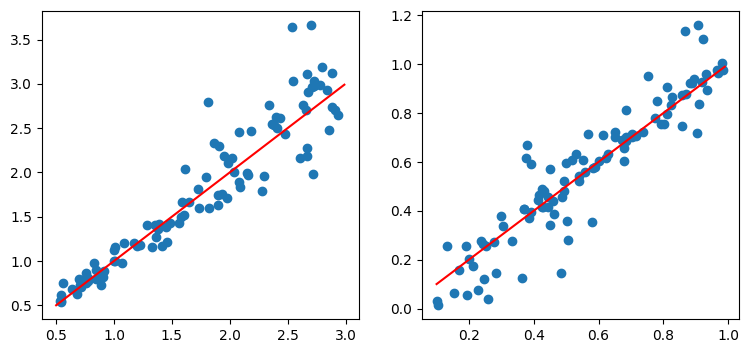

In [11]:
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))

print(r2_score(tr_df.groupby(by='sbj')['true_threshold'].mean(), threshold), 
      r2_score(tr_df.groupby(by='sbj')['true_ndt'].mean(), ndt))

print(pearsonr(tr_df.groupby(by='sbj')['true_threshold'].mean(), threshold)[0], 
      pearsonr(tr_df.groupby(by='sbj')['true_ndt'].mean(), ndt)[0])

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(tr_df.groupby(by='sbj')['true_threshold'].mean(), threshold)
plt.plot(np.arange(0.5, 3, 0.01), np.arange(0.5, 3, 0.01), c='red');

plt.subplot(122)
plt.scatter(tr_df.groupby(by='sbj')['true_ndt'].mean(), ndt)
plt.plot(np.arange(0.1, 1, 0.01), np.arange(0.1, 1, 0.01), c='red');

436/436 [==============================] - 0s 275us/step
0.733879206516834 0.736018756692403
0.8632328042609777 0.8685934174476997


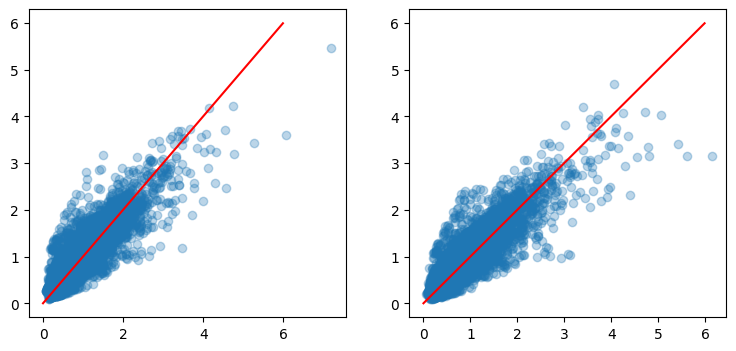

In [14]:
pred_v = model.predict(X_train)
scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in tr_df['sbj']])

print(r2_score(tr_df['true_drift_0'], scaling*pred_v[:, 0]), 
      r2_score(tr_df['true_drift_1'], scaling*pred_v[:, 1]))

print(pearsonr(tr_df['true_drift_0'], scaling*pred_v[:, 0])[0], 
      pearsonr(tr_df['true_drift_1'], scaling*pred_v[:, 1])[0])

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(tr_df['true_drift_0'], scaling*pred_v[:, 0], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');

plt.subplot(122)
plt.scatter(tr_df['true_drift_1'], scaling*pred_v[:, 1], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');

187/187 [==============================] - 0s 316us/step
0.7280835280972761 0.7276540768226922
0.8593964879677682 0.8626215376203995


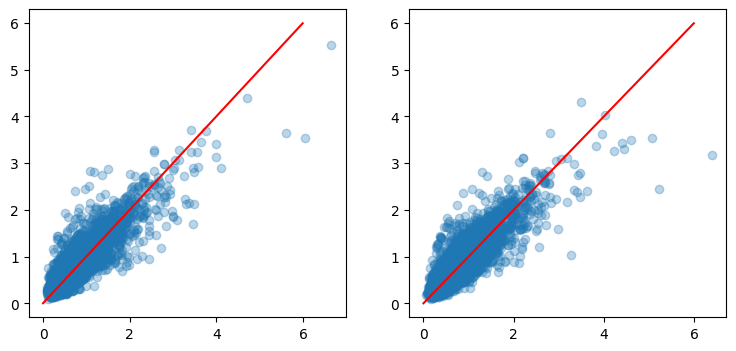

In [15]:
pred_v = model.predict(X_test)
scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

print(r2_score(ts_df['true_drift_0'], scaling*pred_v[:, 0]), 
      r2_score(ts_df['true_drift_1'], scaling*pred_v[:, 1]))

print(pearsonr(ts_df['true_drift_0'], scaling*pred_v[:, 0])[0], 
      pearsonr(ts_df['true_drift_1'], scaling*pred_v[:, 1])[0])

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(ts_df['true_drift_0'], scaling*pred_v[:, 0], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');

plt.subplot(122)
plt.scatter(ts_df['true_drift_1'], scaling*pred_v[:, 1], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');